In [ ]:
#upload model file model.py
from google.colab import files
uploaded = files.upload()

In [31]:
#installing all dependencies
!pip install torchattacks
!pip install torch==1.7.1 torchvision==0.8.2 
!pip install torch-dct

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [32]:
#importing all necessary libraries
import torch_dct as dct
import matplotlib.pyplot as plt
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.utils
from torchvision import models
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import torchattacks
from torchattacks import PGD, FGSM, FFGSM
from pgd_dct import PGD_DCT
from ffgsm_dct import FFGSM_DCT

from models import CNN
import random

In [33]:
#Downloading Fashion MNIST Dataset
train_list_transforms = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
    ])

transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,),)])

fashion_mnist_train = dsets.FashionMNIST(root='./data1/',
                          train=True,
                          transform=train_list_transforms,
                          download=True)

fashion_mnist_test = dsets.FashionMNIST(root='./data1/',
                         train=False,
                         transform=train_list_transforms,
                         download=True)

In [34]:
batch_size = 128
torch.manual_seed(0)

train_loader  = torch.utils.data.DataLoader(dataset=fashion_mnist_train,
                                           batch_size=batch_size,
                                           shuffle=42,num_workers=3,worker_init_fn= lambda id : np.random.seed(id))

test_loader = torch.utils.data.DataLoader(dataset=fashion_mnist_test,
                                         batch_size=batch_size,
                                         shuffle=42,num_workers=3,worker_init_fn= lambda id : np.random.seed(id))

In [35]:
#Accuracy table
df_acc = pd.DataFrame({'Model' : [], 'STD' : [], 'FGSM' : [], 'PGD' : [], 'PGD_DCT' : [], 'FFGSM' : [], 'FFGSM_DCT' : []})

In [36]:
#defining model and parameters
model = CNN().cuda()
model_pgd = CNN().cuda()
model_pgd_dct = CNN().cuda()
model_ffgsm = CNN().cuda()
model_ffgsm_dct = CNN().cuda()

optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer_pgd = optim.Adam(model_pgd.parameters(), lr=0.001)
optimizer_pgd_dct = optim.Adam(model_pgd_dct.parameters(), lr=0.001)
optimizer_ffgsm = optim.Adam(model_ffgsm.parameters(), lr=0.001)
optimizer_ffgsm_dct = optim.Adam(model_ffgsm_dct.parameters(), lr=0.001)

loss = nn.CrossEntropyLoss()
num_epochs = 10

model

CNN(
  (layer): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layer): Sequential(
    (0): Linear(in_features=576, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=10, bias=True)
  )
)

In [37]:
#modified test function with 3 attacks and toggle between Pixel and DCT representation.Default is Pixel

def get_accuracy(model, test_loader, attack=None):
    model.eval()

    correct = 0
    total = 0
    
    if (attack==None):
      atk = lambda x, y: x
    elif (attack=="FGSM") :
      atk = FGSM(model, eps=0.3)
    elif (attack=="PGD") :
      atk = PGD(model, eps=0.3)
    elif (attack=="PGD_DCT") :
      atk = PGD_DCT(model, eps=0.3)
    elif (attack=="FFGSM") :
      atk = FFGSM(model, eps=0.3)
    elif (attack=="FFGSM_DCT") :
      atk = FFGSM_DCT(model, eps=0.3)
    

    for images, labels in test_loader:

        images = atk(images, labels).cuda()              
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels.cuda()).sum()

    acc = 100 * float(correct) / total
    #print(f"Attack: {attack}, Accuracy: {acc}")

    return acc

In [38]:
#train function with PGD attack and toggle between DCT and Pixel representation .Default is Pixel

def train_(model, train_loader, optimizer, loss, attack=None, num_epochs=5):

    model.train()
    
    if (attack==None):
      atk = lambda x, y: x
    elif (attack=="FGSM") :
      atk = FGSM(model, eps=0.3)
    elif (attack=="PGD") :
      atk = PGD(model, eps=0.3)
    elif (attack=="PGD_DCT") :
      atk = PGD_DCT(model, eps=0.3)
    elif (attack=="FFGSM") :
      atk = FFGSM(model, eps=0.3)
    elif (attack=="FFGSM_DCT") :
      atk = FFGSM_DCT(model, eps=0.3)

    for epoch in range(num_epochs):

        total_batch = len(fashion_mnist_train) // batch_size
        
        for i, (batch_images, batch_labels) in enumerate(train_loader):

           
            Y = batch_labels.cuda()
            X = atk(batch_images, batch_labels).cuda()

            pre = model(X)
            cost = loss(pre, Y)

            optimizer.zero_grad()
            cost.backward()
            optimizer.step()

            if (i+1) % 100 == 0:
                print(f'Atk: {attack}, Epoch [{epoch+1}/{num_epochs}], lter [{i+1}/{total_batch}], Loss: {cost.item()}')
    return cost

In [39]:
cost0=train_(model,train_loader,optimizer,loss)

Atk: None, Epoch [1/5], lter [100/468], Loss: 0.6817713379859924
Atk: None, Epoch [1/5], lter [200/468], Loss: 0.573227047920227
Atk: None, Epoch [1/5], lter [300/468], Loss: 0.4903079569339752
Atk: None, Epoch [1/5], lter [400/468], Loss: 0.439993679523468
Atk: None, Epoch [2/5], lter [100/468], Loss: 0.44189631938934326
Atk: None, Epoch [2/5], lter [200/468], Loss: 0.40173161029815674
Atk: None, Epoch [2/5], lter [300/468], Loss: 0.41549959778785706
Atk: None, Epoch [2/5], lter [400/468], Loss: 0.3369978964328766
Atk: None, Epoch [3/5], lter [100/468], Loss: 0.3772985339164734
Atk: None, Epoch [3/5], lter [200/468], Loss: 0.3878646492958069
Atk: None, Epoch [3/5], lter [300/468], Loss: 0.2611545920372009
Atk: None, Epoch [3/5], lter [400/468], Loss: 0.3413501977920532
Atk: None, Epoch [4/5], lter [100/468], Loss: 0.2645367383956909
Atk: None, Epoch [4/5], lter [200/468], Loss: 0.26191282272338867
Atk: None, Epoch [4/5], lter [300/468], Loss: 0.4259136915206909
Atk: None, Epoch [4/5],

In [40]:
std_std_acc = get_accuracy(model, test_loader)
std_fgsm_acc = get_accuracy(model, test_loader, "FGSM")
std_pgd_acc = get_accuracy(model, test_loader, "PGD")
std_pgd_dct_acc = get_accuracy(model, test_loader, "PGD_DCT")
std_ffgsm_acc = get_accuracy(model, test_loader, "FFGSM")
std_ffgsm_dct_acc = get_accuracy(model, test_loader, "FFGSM_DCT")

In [41]:
std_acc = pd.Series(["Std", std_std_acc, std_fgsm_acc, std_pgd_acc, std_pgd_dct_acc, std_ffgsm_acc, std_ffgsm_dct_acc], index=df_acc.columns)
df_acc = df_acc.append(std_acc, ignore_index = True)
df_acc

,Model,STD,FGSM,PGD,PGD_DCT,FFGSM,FFGSM_DCT
0,Std,90.04,48.26,41.62,51.93,61.12,66.04


In [42]:
#Initial training in Pixel representation
cost_pgd0 = train_(model_pgd, train_loader, optimizer_pgd, loss)
cost_pgd1 = train_(model_pgd, train_loader, optimizer_pgd, loss, "PGD")

Atk: None, Epoch [1/5], lter [100/468], Loss: 0.7051586508750916
Atk: None, Epoch [1/5], lter [200/468], Loss: 0.668381929397583
Atk: None, Epoch [1/5], lter [300/468], Loss: 0.46945956349372864
Atk: None, Epoch [1/5], lter [400/468], Loss: 0.37871962785720825
Atk: None, Epoch [2/5], lter [100/468], Loss: 0.40928295254707336
Atk: None, Epoch [2/5], lter [200/468], Loss: 0.45489948987960815
Atk: None, Epoch [2/5], lter [300/468], Loss: 0.3375001847743988
Atk: None, Epoch [2/5], lter [400/468], Loss: 0.226167693734169
Atk: None, Epoch [3/5], lter [100/468], Loss: 0.35293057560920715
Atk: None, Epoch [3/5], lter [200/468], Loss: 0.35371968150138855
Atk: None, Epoch [3/5], lter [300/468], Loss: 0.24604816734790802
Atk: None, Epoch [3/5], lter [400/468], Loss: 0.23009225726127625
Atk: None, Epoch [4/5], lter [100/468], Loss: 0.2866828739643097
Atk: None, Epoch [4/5], lter [200/468], Loss: 0.3719741106033325
Atk: None, Epoch [4/5], lter [300/468], Loss: 0.2695278823375702
Atk: None, Epoch [4

In [43]:
#test accuracy with PGD attack
pgd_std_acc = get_accuracy(model_pgd, test_loader)
pgd_fgsm_acc = get_accuracy(model_pgd, test_loader, "FGSM")
pgd_pgd_acc = get_accuracy(model_pgd, test_loader, "PGD")
pgd_pgd_dct_acc = get_accuracy(model_pgd, test_loader, "PGD_DCT")
pgd_ffgsm_acc = get_accuracy(model_pgd, test_loader, "FFGSM")
pgd_ffgsm_dct_acc = get_accuracy(model_pgd, test_loader, "FFGSM_DCT")

In [44]:
#Save in dataframe
pgd_acc = pd.Series(["Pgd", pgd_std_acc, pgd_fgsm_acc, pgd_pgd_acc, pgd_pgd_dct_acc, pgd_ffgsm_acc, pgd_ffgsm_dct_acc], index=df_acc.columns)
df_acc = df_acc.append(pgd_acc, ignore_index = True)
df_acc

,Model,STD,FGSM,PGD,PGD_DCT,FFGSM,FFGSM_DCT
0,Std,90.04,48.26,41.62,51.93,61.12,66.04
1,Pgd,79.16,78.77,77.27,43.36,84.17,50.08


In [45]:
#Initial training in Pixel representation
cost_pgd_dct0 = train_(model_pgd_dct, train_loader, optimizer_pgd_dct, loss)
cost_pgd_dct1 = train_(model_pgd_dct, train_loader, optimizer_pgd_dct, loss, "PGD_DCT")

Atk: None, Epoch [1/5], lter [100/468], Loss: 0.5856550931930542
Atk: None, Epoch [1/5], lter [200/468], Loss: 0.5148603320121765
Atk: None, Epoch [1/5], lter [300/468], Loss: 0.5190271139144897
Atk: None, Epoch [1/5], lter [400/468], Loss: 0.4926277697086334
Atk: None, Epoch [2/5], lter [100/468], Loss: 0.40920838713645935
Atk: None, Epoch [2/5], lter [200/468], Loss: 0.31705644726753235
Atk: None, Epoch [2/5], lter [300/468], Loss: 0.3982064425945282
Atk: None, Epoch [2/5], lter [400/468], Loss: 0.45284682512283325
Atk: None, Epoch [3/5], lter [100/468], Loss: 0.35021287202835083
Atk: None, Epoch [3/5], lter [200/468], Loss: 0.30483460426330566
Atk: None, Epoch [3/5], lter [300/468], Loss: 0.2515949010848999
Atk: None, Epoch [3/5], lter [400/468], Loss: 0.22583329677581787
Atk: None, Epoch [4/5], lter [100/468], Loss: 0.3641591966152191
Atk: None, Epoch [4/5], lter [200/468], Loss: 0.273802250623703
Atk: None, Epoch [4/5], lter [300/468], Loss: 0.23597560822963715
Atk: None, Epoch [4

In [46]:
#test accuracy with PGD attack
pgd_dct_std_acc = get_accuracy(model_pgd_dct, test_loader)
pgd_dct_fgsm_acc = get_accuracy(model_pgd_dct, test_loader, "FGSM")
pgd_dct_pgd_acc = get_accuracy(model_pgd_dct, test_loader, "PGD")
pgd_dct_pgd_dct_acc = get_accuracy(model_pgd_dct, test_loader, "PGD_DCT")
pgd_dct_ffgsm_acc = get_accuracy(model_pgd_dct, test_loader, "FFGSM")
pgd_dct_ffgsm_dct_acc = get_accuracy(model_pgd_dct, test_loader, "FFGSM_DCT")

In [47]:
#Save in dataframe
pgd_dct_acc = pd.Series(["Pgd_dct", pgd_dct_std_acc, pgd_dct_fgsm_acc, pgd_dct_pgd_acc, pgd_dct_pgd_dct_acc, pgd_dct_ffgsm_acc, pgd_dct_ffgsm_dct_acc], index = df_acc.columns)
df_acc = df_acc.append(pgd_dct_acc, ignore_index = True)
df_acc

,Model,STD,FGSM,PGD,PGD_DCT,FFGSM,FFGSM_DCT
0,Std,90.04,48.26,41.62,51.93,61.12,66.04
1,Pgd,79.16,78.77,77.27,43.36,84.17,50.08
2,Pgd_dct,85.16,65.49,62.93,83.53,78.96,87.16


In [48]:
#Loss when converting from Pixel to DCT

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)


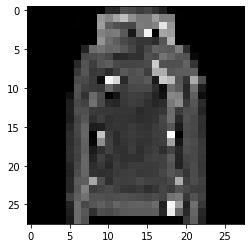

In [49]:
#Pixel representation
import matplotlib.pyplot as plt

fig = plt.figure()

plt.imshow(example_data[0][0], cmap='gray', interpolation='none')





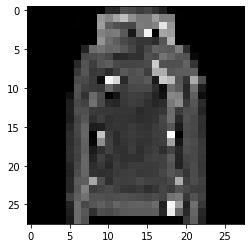

In [50]:
#DCT representation

fig1 = plt.figure()

plt.imshow(dct.idct(dct.dct(example_data[0][0])), cmap='gray', interpolation='none')



In [51]:
#MSE LOSS between the two tensors
input = example_data
target = dct.idct(dct.dct(example_data))
mse_loss = nn.MSELoss()
output = mse_loss(input, target)


#print('input: ', input)
#print('target: ', target)
print('output: ', output)

output:  tensor(2.4257e-14)
